# Import Modules

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Levenshtein Distance Algorithm

In [13]:
def levenshtein_distance(x: str, y: str) -> (int, int):
    # Matrix to store the corresponding edit distances of substring x with respect to y
    m, n = len(x), len(y)
    D = np.zeros((m + 1, n + 1), dtype=int)

    # Initialize first column with each cell being a number corresponding to the position of each character of x
    for i in range(m + 1):
        D[i, 0] = i

    # Initialize first row with each cell being a number corresponding to the position of each character of y
    for j in range(n + 1):
        D[0, j] = j

    # Iterate through each substring in x and compare it with each substring of y
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # If the characters are different (AKA) then the cost for substitution is 1. Else its 0
            cost = 1
            if x[i - 1] == y[j - 1]:
                cost = 0

            # For the minimum edit distance between substring of x up to i and substring of y up to j,
            # find the minimum between:
            # 1. Cost to delete: D[i - 1, j] + 1
            # 2. Cost to insert: D[i, j - 1] + 1
            # 3. Cost to substitute: D[i - 1, j - 1] + cost
            D[i, j] = min(D[i - 1, j] + 1, D[i, j - 1] + 1, D[i - 1, j - 1] + cost)

    # The minimum of edit distance for x and y is the element in the last column and last row of D
    # Returning the sum of D.shapes is needed for memory allocation benchmarking
    return D.shape[0] + D.shape[1], D[m, n]

# Levenshtein Distance with Array instead of Matrix

In [14]:
def arr_levenshtein_distance(x: str, y: str) -> (int, int):
    # We choose the string with the shorter length to memoize the calculations
    m, n = len(x), len(y)

    if m > n:
        x, y = y, x
        m, n = n, m

    # Initialize arrays for previous and current rows
    prev = np.arange(m + 1, dtype=int)
    current = np.zeros(m + 1, dtype=int)

    # Iterate through each substring of the longer string up to index i and compare it to each substring of the shorter string
    for i in range(1, n + 1):
        current[0] = i

        # For the minimum edit distance between substring of the longer string up to i and substring of the shorter substring up to j,
        # find the minimum between:
        # 1. Cost to delete: prev[j] + 1
        # 2. Cost to insert: current[j - 1] + 1
        # 3. Cost to substitute: prev[j - 1] + (0 if the characters are the same else 1)
        for j in range(1, m + 1):
            deletion_cost = prev[j] + 1
            insertion_cost = current[j - 1] + 1
            substitution_cost = prev[j - 1] + (0 if x[j - 1] == y[i - 1] else 1)

            current[j] = min(insertion_cost, deletion_cost, substitution_cost)

        # The current array will be the previous array of the next iteration. In truth, the current array doesn't need to be changed
        # as it will be overwritten in the next iteration anyway
        prev = current.copy()

    # The minimum edit distance can be found in prev[m]. This is the equivalent of D[m, n]
    # Returning the 2 * len(prev) is needed for memory allocation benchmarking
    return 2 * len(prev), prev[m]

# Benchmarking

Loading the dataset

In [11]:
wordpairs = pd.read_csv("data/medinform_similarity_wordpairs.csv")
wordpairs.head()

,IDX_SIM,INPUT1,INPUT1_ENG,INPUT2,INPUT2_ENG
0,1,메르스,MERS,중동호흡기증후군,Middle East respiratory syndrome
1,2,포비돈,povidone,베타딘,betadine
2,3,아픽사반,apixaban,항혈전제,antithrombotic
3,4,진해제,antitussive,코데인,codeine
4,5,발진티푸스,typhus,장티푸스,typhoid


In [12]:
wordpairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IDX_SIM     604 non-null    int64 
 1   INPUT1      604 non-null    object
 2   INPUT1_ENG  604 non-null    object
 3   INPUT2      604 non-null    object
 4   INPUT2_ENG  604 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.7+ KB


## Benchmarking on the English word pairs

In [20]:
wordpairs["total_allocs__standard"] = wordpairs.apply(lambda row: levenshtein_distance(row["INPUT1_ENG"], row["INPUT2_ENG"])[0], axis=1)
wordpairs.head()

,IDX_SIM,INPUT1,INPUT1_ENG,INPUT2,INPUT2_ENG,total_allocs__standard
0,1,메르스,MERS,중동호흡기증후군,Middle East respiratory syndrome,38
1,2,포비돈,povidone,베타딘,betadine,18
2,3,아픽사반,apixaban,항혈전제,antithrombotic,24
3,4,진해제,antitussive,코데인,codeine,20
4,5,발진티푸스,typhus,장티푸스,typhoid,15


In [21]:
wordpairs["total_allocs__array"] = wordpairs.apply(lambda row: arr_levenshtein_distance(row["INPUT1_ENG"], row["INPUT2_ENG"])[0], axis=1)
wordpairs.head()

,IDX_SIM,INPUT1,INPUT1_ENG,INPUT2,INPUT2_ENG,total_allocs__standard,total_allocs__array
0,1,메르스,MERS,중동호흡기증후군,Middle East respiratory syndrome,38,10
1,2,포비돈,povidone,베타딘,betadine,18,18
2,3,아픽사반,apixaban,항혈전제,antithrombotic,24,18
3,4,진해제,antitussive,코데인,codeine,20,16
4,5,발진티푸스,typhus,장티푸스,typhoid,15,14


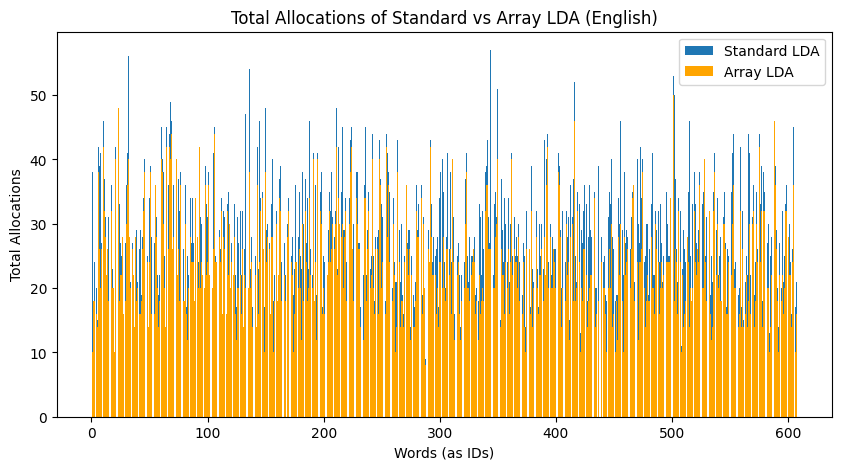

In [46]:
plt.figure(figsize=(10, 5))
plt.bar(wordpairs["IDX_SIM"], wordpairs["total_allocs__standard"])
plt.bar(wordpairs["IDX_SIM"], wordpairs["total_allocs__array"], color="orange")
plt.title("Total Allocations of Standard vs Array LDA (English)")
plt.xlabel("Words (as IDs)")
plt.ylabel("Total Allocations")
plt.legend(["Standard LDA", "Array LDA"])
plt.show()

## Benchmarking on the Korean word pairs

In [34]:
wordpairs["total_allocs_korean__standard"] = wordpairs.apply(lambda row: levenshtein_distance(row["INPUT1"], row["INPUT2"])[0], axis=1)
wordpairs.head()

,IDX_SIM,INPUT1,INPUT1_ENG,INPUT2,INPUT2_ENG,total_allocs__standard,total_allocs__array,total_allocs_korean__standard
0,1,메르스,MERS,중동호흡기증후군,Middle East respiratory syndrome,38,10,13
1,2,포비돈,povidone,베타딘,betadine,18,18,8
2,3,아픽사반,apixaban,항혈전제,antithrombotic,24,18,10
3,4,진해제,antitussive,코데인,codeine,20,16,8
4,5,발진티푸스,typhus,장티푸스,typhoid,15,14,11


In [35]:
wordpairs["total_allocs_korean__array"] = wordpairs.apply(lambda row: arr_levenshtein_distance(row["INPUT1"], row["INPUT2"])[0], axis=1)
wordpairs.head()

,IDX_SIM,INPUT1,INPUT1_ENG,INPUT2,INPUT2_ENG,total_allocs__standard,total_allocs__array,total_allocs_korean__standard,total_allocs_korean__array
0,1,메르스,MERS,중동호흡기증후군,Middle East respiratory syndrome,38,10,13,8
1,2,포비돈,povidone,베타딘,betadine,18,18,8,8
2,3,아픽사반,apixaban,항혈전제,antithrombotic,24,18,10,10
3,4,진해제,antitussive,코데인,codeine,20,16,8,8
4,5,발진티푸스,typhus,장티푸스,typhoid,15,14,11,10


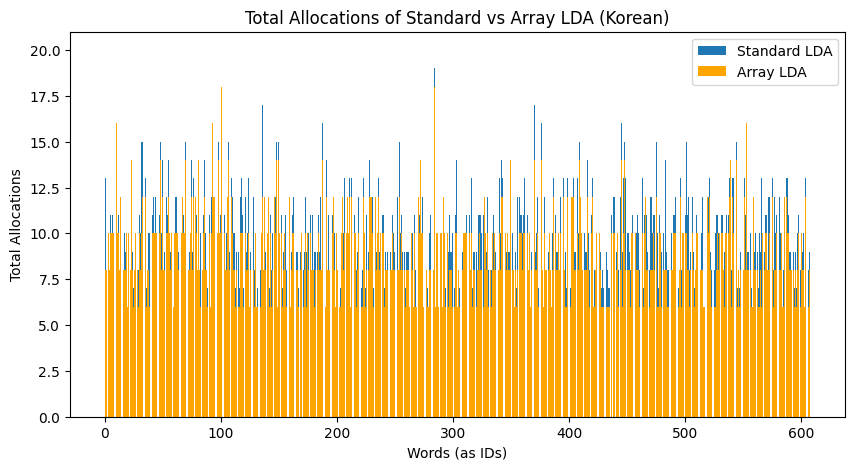

In [45]:
plt.figure(figsize=(10, 5))
plt.bar(wordpairs["IDX_SIM"], wordpairs["total_allocs_korean__standard"])
plt.bar(wordpairs["IDX_SIM"], wordpairs["total_allocs_korean__array"], color="orange")
plt.title("Total Allocations of Standard vs Array LDA (Korean)")
plt.xlabel("Words (as IDs)")
plt.ylabel("Total Allocations")
plt.legend(["Standard LDA", "Array LDA"])
plt.show()